Available columns in dataset: Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour', 'name', 'flight_duration', 'day_of_week', 'total_delay'],
      dtype='object')
Model Accuracy: 1.0
F1 Score: 1.0
ROC-AUC Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     49987
           1       1.00      1.00      1.00     10196

    accuracy                           1.00     60183
   macro avg       1.00      1.00      1.00     60183
weighted avg       1.00      1.00      1.00     60183


Confusion Matrix:
 [[49987     0]
 [    0 10196]]


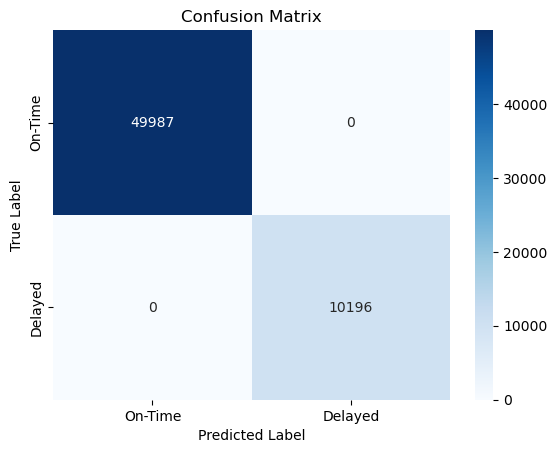

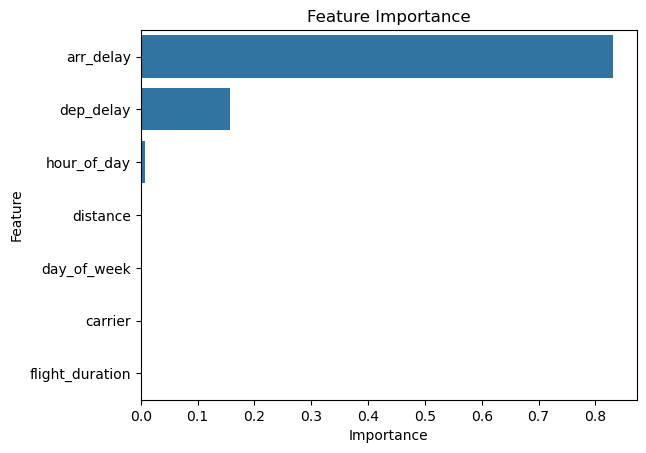

2024-11-12 10:35:59.021647: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 10:35:59.022879: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 10:35:59.046541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 10:35:59.785581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. M


Generated Recommendations:
 
Based on flight delay predictions, airlines should consider these action steps:
- High likelihood of delay: Investigate common causes such as weather disruptions, maintenance issues, or crew availability.
- Moderate likelihood of delay: Monitor potential risks and plan for mitigating moderate disruptions.
- Low likelihood of delay: Continue regular operations with periodic checks to ensure efficiency.

What strategies should airline management implement to reduce delays and improve customer satisfaction?

Airline managers can implement a number of strategies to reduce delayed arrivals and departures by reducing flight delays. One strategy to reduce delayed arrivals is to reduce service and passenger satisfaction by reducing service at multiple stops and for longer delays at airports. Another approach is to reduce service from other stations when possible until they've had enough time to respond to your request.

Airline managers make good economic sense by

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('./DataSets/KaggleData/flights_gold.csv')

# Display available columns in the dataset
print("Available columns in dataset:", df.columns)

# Handle missing values in important columns
df['arr_delay'].fillna(df['arr_delay'].mean(), inplace=True)
df['dep_delay'].fillna(df['dep_delay'].mean(), inplace=True)

# Convert year, month, and day into a single datetime feature (flight_date)
df['flight_date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Extract additional time-based features
df['day_of_week'] = df['flight_date'].dt.dayofweek
df['hour_of_day'] = df['dep_time'].astype(str).str.replace(r'\.', '', regex=True).str.slice(0, 2).astype(int)

# Fill missing values for other numeric columns (e.g., flight_duration, distance)
df['flight_duration'].fillna(df['flight_duration'].mean(), inplace=True)
df['distance'].fillna(df['distance'].mean(), inplace=True)

# Encode categorical features
le_carrier = LabelEncoder()
df['carrier'] = le_carrier.fit_transform(df['carrier'])

# Feature selection
features = ['day_of_week', 'hour_of_day', 'dep_delay', 'arr_delay', 'carrier', 'distance', 'flight_duration']
X = df[features]

# Create a binary target variable based on arrival delay
df['target_binary'] = (df['arr_delay'] > 15).astype(int)
df.dropna(subset=['target_binary'], inplace=True)

# Define X (features) and y (target)
X = df[features]
y = df['target_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model with additional metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", conf_matrix)

# Visualize the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['On-Time', 'Delayed'], yticklabels=['On-Time', 'Delayed'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Feature importance analysis
feature_importances = model.feature_importances_
feature_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importance")
plt.show()

# Summary and actionable recommendations generation
from transformers import pipeline

# Initialize a text generator
generator = pipeline('text-generation', model='gpt2')

prompt = """
Based on flight delay predictions, airlines should consider these action steps:
- High likelihood of delay: Investigate common causes such as weather disruptions, maintenance issues, or crew availability.
- Moderate likelihood of delay: Monitor potential risks and plan for mitigating moderate disruptions.
- Low likelihood of delay: Continue regular operations with periodic checks to ensure efficiency.

What strategies should airline management implement to reduce delays and improve customer satisfaction?
"""

# Generate recommendations text
generated_text = generator(prompt, max_length=200, num_return_sequences=1)
print("\nGenerated Recommendations:\n", generated_text[0]['generated_text'])
